## Importing required libraries

In [1]:
import sys 
sys.path.append('/home/aistudio/external-libraries')

import jax 
import jax.numpy as jnp
import optax
import jaxopt
from jax import device_put

jax.config.update("jax_enable_x64", True)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Defining the Delay Differential Equation

Consider the delay differential equation with a single time delay on the solution interval $[0,10]$:

\begin{equation}
\begin{cases}
\begin{aligned}
        y'(t) = {}& -y(t-\tau),\qquad & t \geq 0\\
        y(t) = {}& 1, & t \leq 0
\end{aligned}
\end{cases}.
\end{equation}

In [2]:
# Define the time dela parameter
# lag = 0.5
# lag = 1.
lag = 1.5

# Define the differential equation
def DDE(t, u, lag):
    # Define u'(t)
    u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)))(t)

    # Define the right-hand side of the DDE
    rhs = jnp.where(t > lag, u(t - lag), 1)
    return u_t(t) + rhs


In [ ]:
# N_i represents the number of boundary conditions, conds represents the initial condition y(0) = 1
N_i = 1
t0 = jnp.ones([N_i, 1], dtype='float64') * 0.0
u0 = jnp.ones_like(t0)
conds = jnp.concatenate([t0, u0], axis=1)

# Initial key for random number generator
ik = 0

# Number of internal random points
N_f = 5000

# Range for sampling points
tmin, tmax = 0.0, 10.

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)
inPoints = jax.random.uniform(jaxKey, minval=tmin, maxval=tmax, shape=(N_f,1), dtype='float64')

## DNNs Model Definition and Parameter Initialization

In [3]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[:-1]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)
        
    w, b = params[-1]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    # Define lower and upper bounds for Xavier initialization
    lb, ub = -(1/jnp.sqrt(m)), (1/jnp.sqrt(n)) 

    w_key, b_key = jax.random.split(key)
    return lb + (ub-lb) * jax.random.uniform(w_key, (m, n)), jax.random.uniform(b_key, (n,))

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Defining the loss function

In [4]:
@jax.jit
def loss_fun(params, inPoints, conds):
    t_c = inPoints[:, [0]]
    ufunc = lambda t: DNNs(params, t)

    # Loss from the differential equation
    loss_f = jnp.mean(DDE(t_c, ufunc, lag)**2)

    # Loss from the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_i = jnp.mean((ufunc(t_0) - u_0)**2)

    loss_total = loss_f + loss_i
    w_f = loss_f/loss_total
    w_i = loss_i/loss_total

    return loss_f*w_f + loss_i*w_i

## DNNs initialization

In [6]:
# Network architecture
netLayers = [1, 20,40,20, 1]

# Initialize network parameters
key1 = jax.random.PRNGKey(ik)
params = init_network_params(netLayers, key1)

In [7]:
# Initialize the list to store loss history
loss_history = []

# Define the number of training epochs
epochs = 80000

# Define the ADAM optimizer with exponential decay learning rate scheduler
scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=10000, decay_rate=0.9)
optimizer = optax.adam(learning_rate=scheduler)

# Initialize the optimizer state
opt_state = optimizer.init(params)

# Define the update step, decorated with 'jax.jit' for performance optimization
@jax.jit
def update(params, opt_state, inPoints, conds):
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fun)(params, inPoints, conds)
    # Update parameters based on gradients
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Training loop
for epoch in range(epochs):
    # Update parameters and optimizer state, and record loss
    params, opt_state, loss = update(params, opt_state, inPoints, conds)
    loss_history.append(loss)
    # Log loss every 2000 epochs
    if epoch % 2000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 0, Loss: 57.571198903536
Epoch 2000, Loss: 0.018619157748975355
Epoch 4000, Loss: 0.01479931106581207
Epoch 6000, Loss: 0.012661207954185412
Epoch 8000, Loss: 0.009105585255792829
Epoch 10000, Loss: 0.0062792671697961535
Epoch 12000, Loss: 0.004546582411728223
Epoch 14000, Loss: 0.0030297747991274524
Epoch 16000, Loss: 0.00257898916915392
Epoch 18000, Loss: 0.0012418149394640085
Epoch 20000, Loss: 0.0006860282241757771
Epoch 22000, Loss: 0.0002675811051359538
Epoch 24000, Loss: 0.003160629933222143
Epoch 26000, Loss: 0.00014150929427791004
Epoch 28000, Loss: 0.000124756595083868
Epoch 30000, Loss: 0.00010686523268134244
Epoch 32000, Loss: 7.426653960204612e-05
Epoch 34000, Loss: 6.588430854851105e-05
Epoch 36000, Loss: 4.460896707836578e-05
Epoch 38000, Loss: 3.431557628555236e-05
Epoch 40000, Loss: 3.0313750217036358e-05
Epoch 42000, Loss: 3.640597289013992e-05
Epoch 44000, Loss: 2.0942795770926866e-05
Epoch 46000, Loss: 2.0723513855493137e-05
Epoch 48000, Loss: 1.92815913363867

The delay differential equation has an explicit analytical solution, which can be specifically expressed as

\begin{equation}  
    y(t) = 1 + \sum_{k=1}^{n} (-1)^k \dfrac{\left[t - (k-1)\tau \right]^k}{k!}, \quad t \in [(n-1)\tau, n\tau], \quad n \in \mathbb{N}.
\end{equation}

In [8]:
# Calculate the number of intervals (stages)
N = np.floor((tmax - tmin) / lag).astype(np.int32)
t0 = tmin  # Initialize starting time t0
tmax2 = N * lag  # Calculate the total time span

# Define the number of segments per stage and total number of points
nSeg = 100  
rr_sol = np.ones((nSeg * N + 1, 1))  # Initialize the real solution array

# Create a time array linearly spaced within the time interval
T = np.linspace(tmin, tmax2, nSeg * N + 1).reshape(-1, 1)

# Loop over each stage to compute the solution
for n in range(1, N + 1):
    nstart = (n - 1) * nSeg + 1  # Start index for the current stage
    nend = nstart + nSeg  # End index for the current stage
    tPhase = T[nstart:nend, 0]  # Time points for the current phase

    # Compute the solution using the series expansion
    for k in range(1, n + 1):
        rr_sol[nstart:nend, 0] += (-1) ** (k) / math.factorial(k) * ((tPhase - (k - 1) * lag) ** k)

## Result visualization

the L2 relative error is : 0.0028264291882038155


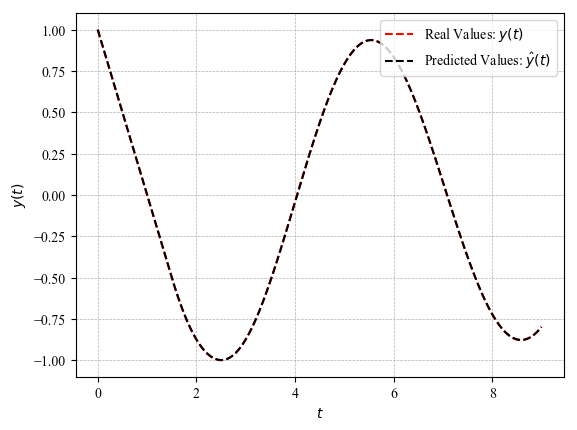

In [9]:
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

nn_sol = DNNs(params,T.reshape(-1,1))

q = np.linalg.norm(rr_sol, ord=2)
p = np.linalg.norm(nn_sol-rr_sol, ord=2)
print("the L2 relative error is :", p/q)

plt.plot(T,rr_sol,'--r',label='Real Values: $y(t)$')
plt.plot(T,nn_sol,'--k',label='Predicted Values: $\hat{y}(t)$')

plt.legend(prop=prop, loc='upper right')

plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y(t)$', fontproperties=prop)

ax = plt.gca()

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# plt.savefig(f'DDE_FP_lag_{lag}.png', dpi=600, bbox_inches='tight')

plt.show()

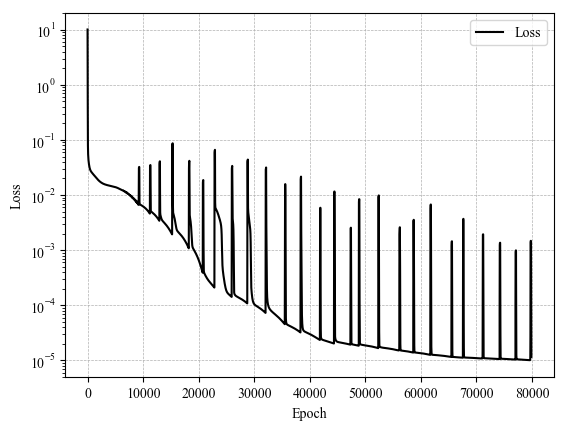

In [10]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 100

smoothed_loss_history = moving_average(loss_history, window_size)

plt.figure(figsize=(16 / 2.54, 12 / 2.54))

plt.plot(list(range(len(smoothed_loss_history))), smoothed_loss_history, 'k',label='Loss')

plt.yscale('log')

plt.legend(prop=prop, loc='upper right')

plt.xlabel('Epoch', fontproperties=prop)
plt.ylabel('Loss', fontproperties=prop)

ax = plt.gca()

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# plt.savefig(f'DDE_FP_lag_{lag}_loss.png', dpi=600, bbox_inches='tight')

plt.show()